## Trend Classification Models - Random Forest, XGBoost, & MLP Classifier

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
data= yf.Ticker('GOOG')
data = data.history(period= 'max')
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,0.0,0.0
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,0.0,0.0
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,0.0,0.0


In [3]:
df = data.copy()

### Add relevant details

In these models, I will use data from previous sessions to predict the trend of the next day. Data I will be adding will be: RSI-14, EMA-20, EMA-50, EMA-100, volumes of the previous day, and the closing price of the last 29 days. Together with the opening, closing, high and low prices of the current day, they will be used to predict the trend of 1 next day.

In [4]:
# Add last day volume, RSI and EMA information
df['Volume-1'] = df['Volume'].shift(1)
df['RSI14'] = ta.rsi(df.Close, length= 14)
df['EMA20'] = ta.ema(df.Close, length= 20)
df['EMA50'] = ta.ema(df.Close, length= 50)
df['EMA100'] = ta.ema(df.Close, length= 100)
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume-1,RSI14,EMA20,EMA50,EMA100
Date,,,,,,,,,,,,
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,0.0,0.0,23087900.0,70.150003,117.003756,110.197200,105.627624
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,0.0,0.0,33812700.0,71.464600,117.806256,110.794565,106.019750
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,0.0,0.0,25154700.0,69.068440,118.457088,111.337523,106.388468
2023-05-31 00:00:00-04:00,123.699997,124.900002,123.099998,123.370003,41548800,0.0,0.0,27230700.0,65.279141,118.924985,111.809385,106.724736
2023-06-01 00:00:00-04:00,123.500000,125.040001,123.300003,124.370003,25009300,0.0,0.0,41548800.0,66.822629,119.443558,112.301958,107.074147


In [5]:
# Add closing price of all 29 days before
for i in range(1, 30):
    df[f'Close-{i}'] = df['Close'].shift(i)
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume-1,RSI14,EMA20,...,Close-20,Close-21,Close-22,Close-23,Close-24,Close-25,Close-26,Close-27,Close-28,Close-29
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,0.0,0.0,23087900.0,70.150003,117.003756,...,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,109.459999
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,0.0,0.0,33812700.0,71.464600,117.806256,...,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,0.0,0.0,25154700.0,69.068440,118.457088,...,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003
2023-05-31 00:00:00-04:00,123.699997,124.900002,123.099998,123.370003,41548800,0.0,0.0,27230700.0,65.279141,118.924985,...,105.980003,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997
2023-06-01 00:00:00-04:00,123.500000,125.040001,123.300003,124.370003,25009300,0.0,0.0,41548800.0,66.822629,119.443558,...,106.120003,105.980003,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002


Let's now add the target variable: next day's trend. Now, it's obvious that the most recent day cannot be used to fit the model, as there's no status for the next day. However, we still need to keep it in order to optimise the scaler, so I will temporarily add a trend, then remove it later.

In [6]:
# Add target variable: next day's trend
df['Next Day Status'] = (df['Close'] > df['Close-1'])
df['Next Day Status'] = df['Next Day Status'].shift(-1)
df.iloc[-1] = df.iloc[-1].fillna(0)
df['Next Day Status'] = df['Next Day Status'].astype(int)
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume-1,RSI14,EMA20,...,Close-21,Close-22,Close-23,Close-24,Close-25,Close-26,Close-27,Close-28,Close-29,Next Day Status
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,0.0,0.0,23087900.0,70.150003,117.003756,...,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,109.459999,1
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,0.0,0.0,33812700.0,71.464600,117.806256,...,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,0
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,0.0,0.0,25154700.0,69.068440,118.457088,...,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,0
2023-05-31 00:00:00-04:00,123.699997,124.900002,123.099998,123.370003,41548800,0.0,0.0,27230700.0,65.279141,118.924985,...,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,1
2023-06-01 00:00:00-04:00,123.500000,125.040001,123.300003,124.370003,25009300,0.0,0.0,41548800.0,66.822629,119.443558,...,105.980003,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,0


In [7]:
# Drop redundant columns
df.drop(['Dividends', 'Stock Splits'], axis= 1, inplace= True)
df.tail(5)

,Open,High,Low,Close,Volume,Volume-1,RSI14,EMA20,EMA50,EMA100,...,Close-21,Close-22,Close-23,Close-24,Close-25,Close-26,Close-27,Close-28,Close-29,Next Day Status
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-25 00:00:00-04:00,125.209999,125.980003,122.900002,124.349998,33812700,23087900.0,70.150003,117.003756,110.197200,105.627624,...,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,109.459999,1
2023-05-26 00:00:00-04:00,124.065002,126.000000,123.290001,125.430000,25154700,33812700.0,71.464600,117.806256,110.794565,106.019750,...,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,0
2023-05-30 00:00:00-04:00,126.290001,126.379997,122.889999,124.639999,27230700,25154700.0,69.068440,118.457088,111.337523,106.388468,...,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,0
2023-05-31 00:00:00-04:00,123.699997,124.900002,123.099998,123.370003,41548800,27230700.0,65.279141,118.924985,111.809385,106.724736,...,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,1
2023-06-01 00:00:00-04:00,123.500000,125.040001,123.300003,124.370003,25009300,41548800.0,66.822629,119.443558,112.301958,107.074147,...,105.980003,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,0


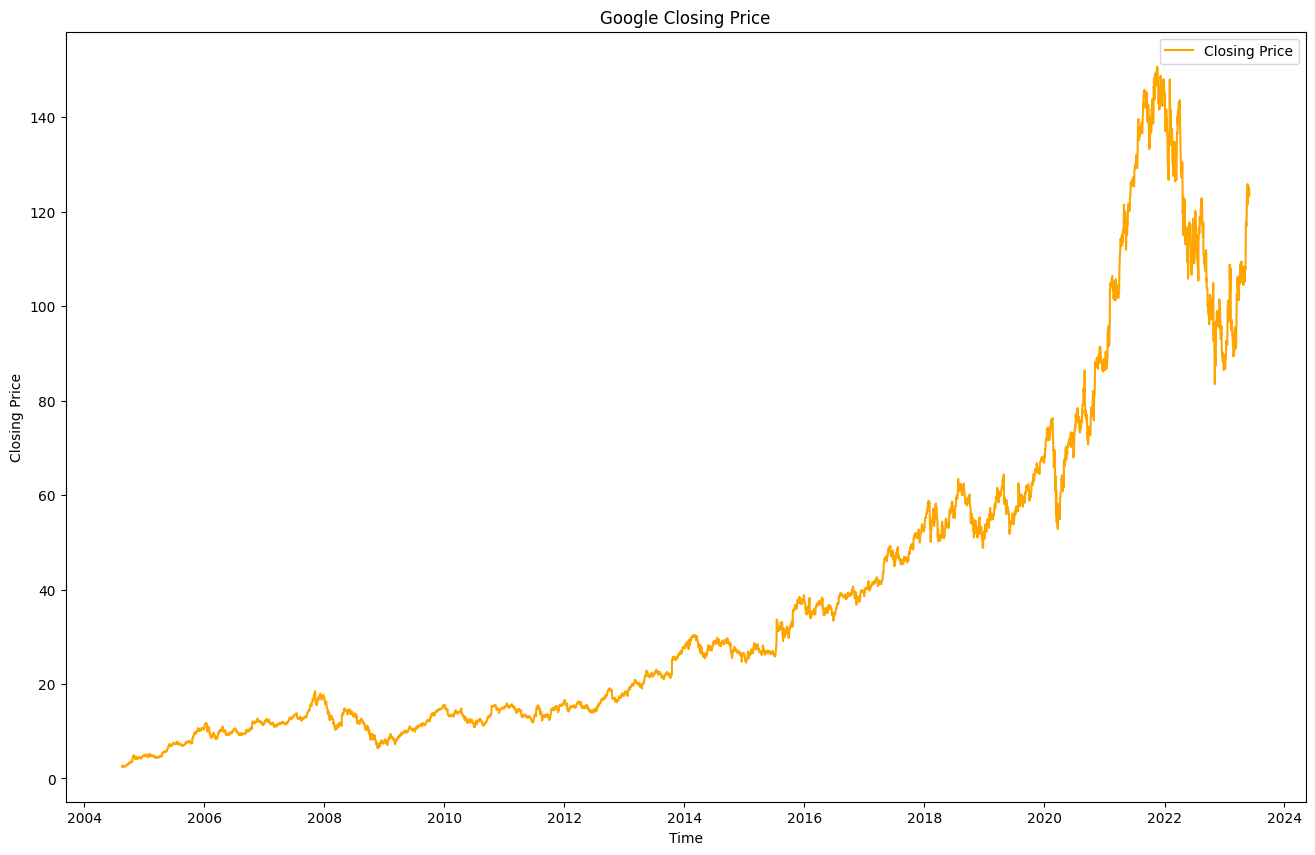

In [8]:
plt.figure(figsize= (16,10))
plt.title('Google Closing Price')
plt.plot(data['Close'], color= 'orange', label= 'Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

We can see that the closing price of Google has witnessed a greater increase after 2015 as compared to the preceding years. Thus, I'm selecting the data from 2015 to put in the model.

In [9]:
# Find the earliest dates that the Google stock market opens in 2015
df = df.reset_index()
df[df['Date'].dt.strftime('%Y').str.contains('2015')]
df.head(5)

,Date,Open,High,Low,Close,Volume,Volume-1,RSI14,EMA20,EMA50,...,Close-21,Close-22,Close-23,Close-24,Close-25,Close-26,Close-27,Close-28,Close-29,Next Day Status
0,2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,897427216.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,458857488.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,366857939.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,306396159.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [10]:
# Select df from 2015 until the most recent one
df = df.loc[2611:]
df.drop(['Date'], axis= 1, inplace= True)
df

,Open,High,Low,Close,Volume,Volume-1,RSI14,EMA20,EMA50,EMA100,...,Close-21,Close-22,Close-23,Close-24,Close-25,Close-26,Close-27,Close-28,Close-29,Next Day Status
2611,26.378078,26.490770,26.133251,26.168653,28951268,27364925.0,47.476958,26.248576,26.650909,27.146795,...,26.614429,26.616922,27.017324,26.944525,26.979927,26.889673,26.801416,26.668282,26.775988,0
2612,26.091366,26.144720,25.582764,25.623152,41196796,28951268.0,40.461823,26.189012,26.610605,27.116623,...,26.493263,26.614429,26.616922,27.017324,26.944525,26.979927,26.889673,26.801416,26.668282,0
2613,25.679497,25.738087,24.983908,25.029282,57998800,41196796.0,34.487426,26.078561,26.548592,27.075290,...,26.791943,26.493263,26.614429,26.616922,27.017324,26.944525,26.979927,26.889673,26.801416,0
2614,25.280592,25.292759,24.914099,24.986401,41301082,57998800.0,34.095946,25.974546,26.487330,27.033926,...,26.191092,26.791943,26.493263,26.614429,26.616922,27.017324,26.944525,26.979927,26.889673,1
2615,24.831326,25.105074,24.482782,25.065184,67071641,41301082.0,35.543608,25.887940,26.431560,26.994941,...,26.276857,26.191092,26.791943,26.493263,26.614429,26.616922,27.017324,26.944525,26.979927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4724,125.209999,125.980003,122.900002,124.349998,33812700,23087900.0,70.150003,117.003756,110.197200,105.627624,...,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,109.459999,1
4725,124.065002,126.000000,123.290001,125.430000,25154700,33812700.0,71.464600,117.806256,110.794565,106.019750,...,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,106.419998,0
4726,126.290001,126.379997,122.889999,124.639999,27230700,25154700.0,69.068440,118.457088,111.337523,106.388468,...,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,105.120003,0
4727,123.699997,124.900002,123.099998,123.370003,41548800,27230700.0,65.279141,118.924985,111.809385,106.724736,...,107.709999,108.220001,108.370003,104.449997,104.610001,106.779999,105.910004,105.900002,105.019997,1


In [11]:
# Scale data
scaler = MinMaxScaler(feature_range= (0,1))
scaled_df = scaler.fit_transform(df)
scaled_df

array([[0.01346944, 0.01381708, 0.0145091 , ..., 0.01671208, 0.01756588,
        0.        ],
       [0.01121538, 0.01110017, 0.01012541, ..., 0.01776746, 0.01671208,
        0.        ],
       [0.00797739, 0.00790761, 0.00535655, ..., 0.01846709, 0.01776746,
        0.        ],
       ...,
       [0.79894848, 0.79806713, 0.78501111, ..., 0.63781696, 0.63860972,
        0.        ],
       [0.77858661, 0.78644739, 0.78668339, ..., 0.64479288, 0.63781696,
        1.        ],
       [0.77701429, 0.78754655, 0.78827609, ..., 0.64487217, 0.64479288,
        0.        ]])

In [12]:
# Remove the last row
scaled_df = scaled_df[:-2, :]

In [13]:
scaled_df

array([[0.01346944, 0.01381708, 0.0145091 , ..., 0.01671208, 0.01756588,
        0.        ],
       [0.01121538, 0.01110017, 0.01012541, ..., 0.01776746, 0.01671208,
        0.        ],
       [0.00797739, 0.00790761, 0.00535655, ..., 0.01846709, 0.01776746,
        0.        ],
       ...,
       [0.79045782, 0.7949267 , 0.78509076, ..., 0.64891496, 0.67301347,
        1.        ],
       [0.78145618, 0.7950837 , 0.78819644, ..., 0.63860972, 0.64891496,
        0.        ],
       [0.79894848, 0.79806713, 0.78501111, ..., 0.63781696, 0.63860972,
        0.        ]])

In [14]:
# Split data into train and test data
train_df, test_df = train_test_split(scaled_df, test_size= 0.2, random_state= 0)

X_train = train_df[:, :-1]
y_train = train_df[:, -1]

X_test = test_df[:, :-1]
y_test = test_df[:, -1]

### Random Forest Model

In [15]:
# Find the optimal depth for the model
best_accuracy = 0
best_max_depth = 0
for i in range(1, 101):
  model = RandomForestClassifier(max_depth= i, n_estimators= 100, random_state= 0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_max_depth = i

print('Best max depth:', best_max_depth)
print('Accuracy at best max depth:', best_accuracy)

Best max depth: 7
Accuracy at best max depth: 0.5636792452830188


In [16]:
# Fit the model
rf = RandomForestClassifier(max_depth= best_max_depth, n_estimators= 200, random_state= 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

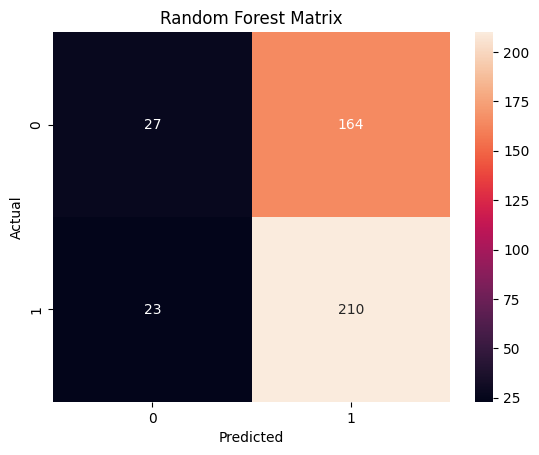

In [17]:
# Evaluate the model
rf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(rf_matrix, annot= True, fmt= 'g')
plt.title(label= 'Random Forest Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
rf_accuracy = accuracy_score(y_test, y_pred)
print('Random Forest accuracy:', rf_accuracy)

Random Forest accuracy: 0.5589622641509434


### XGBoost Model with Logistic Regression

In [19]:
# Find the optimal depth for the model
best_accuracy = 0
best_max_depth = 0
for i in range(1, 101):
  model = XGBClassifier(objective= 'binary:logistic', n_estimators= 100, max_depth= i)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_max_depth = i

print('Best max depth:', best_max_depth)
print('Accuracy at best max depth:', best_accuracy)

Best max depth: 34
Accuracy at best max depth: 0.5636792452830188


In [20]:
# Fit the model
xgb = XGBClassifier(objective='binary:logistic', n_estimators= 200, max_depth= best_max_depth)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

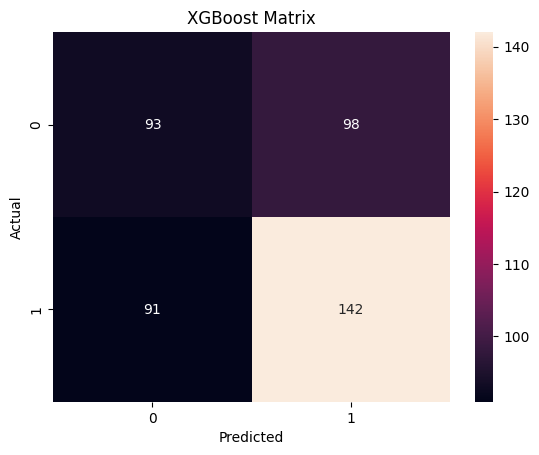

In [21]:
# Evaluate the model
XGB_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(XGB_matrix, annot= True, fmt= 'g')
plt.title(label= 'XGBoost Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
XGB_accuracy = accuracy_score(y_test, y_pred)
print('Random Forest accuracy:', XGB_accuracy)

Random Forest accuracy: 0.5542452830188679


### MLP Classifier Model

In [23]:
# Reshape the data to the size that fits the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape,y_train.shape)

(1692, 39, 1) (1692,)


In [24]:
y_train

array([1., 1., 1., ..., 0., 0., 1.])

In [25]:
# Create and fit the model
mlp = Sequential()
mlp.add(Dense(64, input_shape= (X_train.shape[1],), activation= 'relu'))
mlp.add(Dense(32, activation= 'relu'))
mlp.add(Dense(1, activation= 'sigmoid'))
mlp.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= 'accuracy')

mlp.fit(X_train, y_train, epochs= 200, batch_size= 16)


Epoch 1/200
106/106 [==============================] - 2s 2ms/step - loss: 0.6953 - accuracy: 0.5130
Epoch 2/200
106/106 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5290
Epoch 3/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.5177
Epoch 4/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5242
Epoch 5/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5207
Epoch 6/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5284
Epoch 7/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5266
Epoch 8/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5284
Epoch 9/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5254
Epoch 10/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6921 - accura

In [26]:
y_pred = mlp.predict(X_test).flatten()

print(y_pred)

14/14 [==============================] - 0s 2ms/step
[5.3122890e-01 5.2168101e-01 5.2413028e-01 5.5970395e-01 5.2335048e-01
 5.2757758e-01 3.6792192e-01 5.2739370e-01 5.3464365e-01 5.9034032e-01
 5.2016991e-01 4.5100227e-01 5.3400111e-01 4.1108593e-01 5.2212054e-01
 5.6965929e-01 5.3957939e-01 5.3999579e-01 5.1214361e-01 5.8971149e-01
 3.6441728e-01 5.2387810e-01 5.4426587e-01 5.2701676e-01 5.4227871e-01
 5.3295445e-01 7.8079915e-01 5.2621967e-01 5.3589410e-01 5.2677923e-01
 5.4990029e-01 5.7873899e-01 5.4549634e-01 5.4444534e-01 5.2419525e-01
 5.3856188e-01 5.4123533e-01 5.1389533e-01 5.4002368e-01 5.3570008e-01
 5.4161221e-01 4.6714529e-01 5.8311856e-01 5.2326995e-01 5.3399003e-01
 5.3697401e-01 5.2279979e-01 5.6005591e-01 5.9440762e-01 4.4843879e-01
 5.2873182e-01 5.4161400e-01 8.3597279e-01 5.2229238e-01 6.1241847e-01
 5.3285140e-01 5.1614809e-01 5.8948654e-01 5.2192307e-01 5.3659278e-01
 5.3925538e-01 5.3173178e-01 5.1462442e-01 3.6007035e-01 6.6267097e-01
 5.5528486e-01 5.3354257

In [27]:
print(y_test)

[0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.

In [28]:
y_pred_prob = (y_pred > 0.5).astype(int)
y_pred_prob


array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,

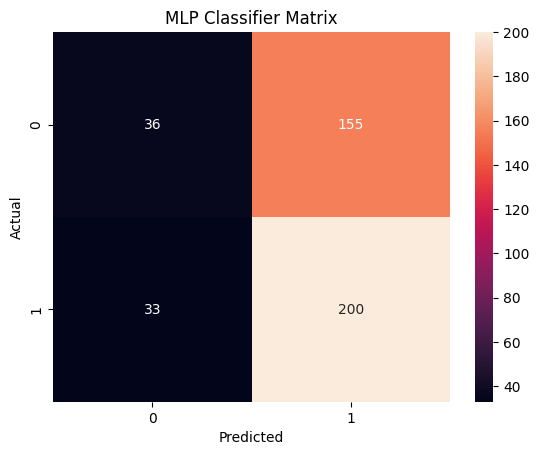

In [29]:
# Evaluate the model
mlp_matrix = confusion_matrix(y_test, y_pred_prob)
sns.heatmap(mlp_matrix, annot= True, fmt= 'g')
plt.title(label= 'MLP Classifier Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Now, the issue seems to be that much like random forest and XGBoost, this model predicts an increase much more than the decrease in price. Let's look into it.

In [30]:
mlp_accuracy = accuracy_score(y_test, y_pred_prob)
print('MLP Classifier accuracy:', mlp_accuracy)

MLP Classifier accuracy: 0.5566037735849056


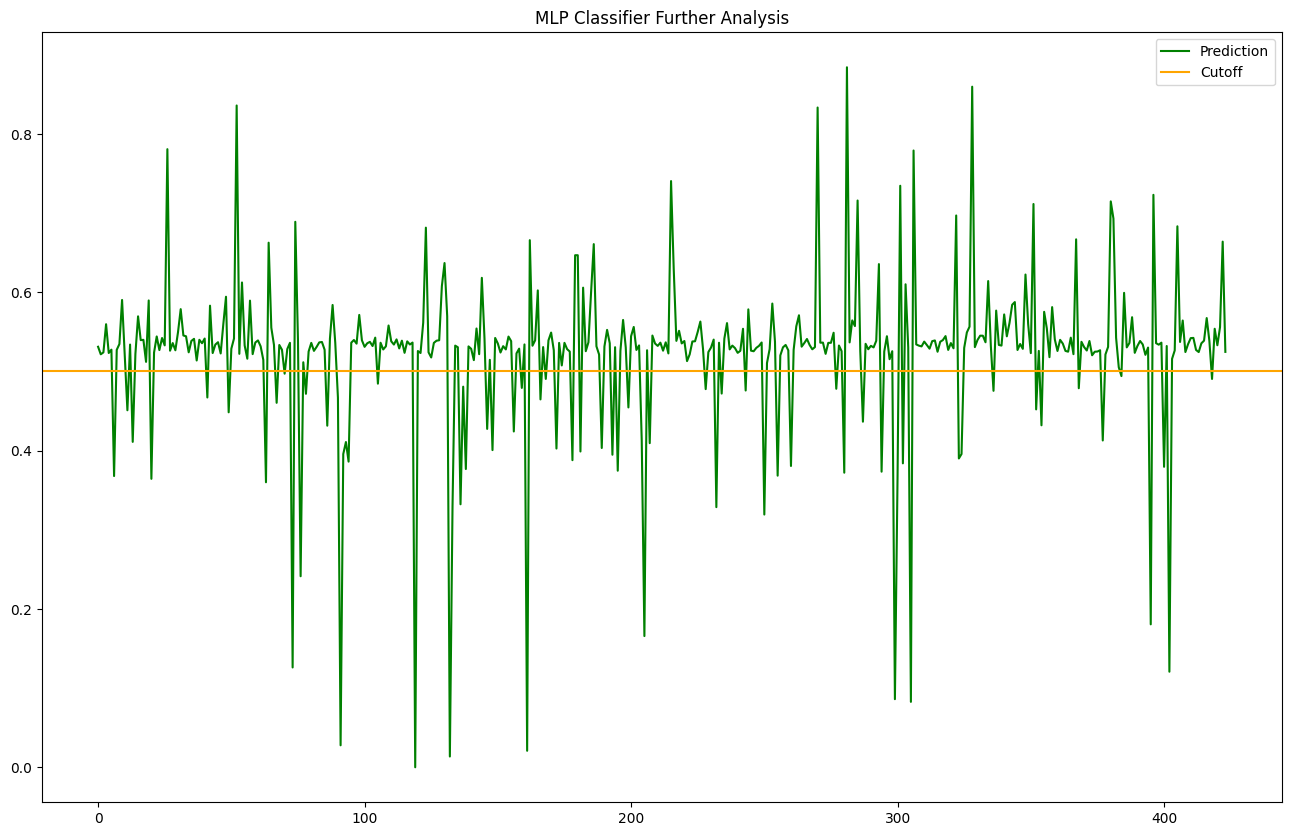

In [31]:
# Plot the full result of the MLP classifier, with a cutoff at 0.5
plt.figure(figsize= (16,10))
plt.title('MLP Classifier Further Analysis')
plt.plot(y_pred, color= 'green', label= 'Prediction')
plt.axhline(y= 0.5, color= 'orange', label= 'Cutoff')
plt.legend()
plt.show()